## Download the dataset

**Download and prepare the dataset**

### Import libraries

In [1]:
try:
  import pydicom
except:
  !pip install pydicom
  import pydicom

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
from PIL import Image

import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00


### Downlaod dataset directly from kaggle to colab

In [2]:
!chmod 600 /content/kaggle.json #how to keep our api key unavailabe to others

!pip install --upgrade --force-reinstall --no-deps kaggle # update kaggle api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110685 sha256=632bf45b66d6b34fd675d624dd431f9aff4015d81275d7bfe963d96191108bcf
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.15
    Uninstalling kaggle-1.5.15:
      Successfully uninstalled kaggle-1.5.15


In [3]:
# Get data directly from kaggle
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [01:59<00:00, 39.0MB/s]
100% 3.66G/3.66G [01:59<00:00, 32.8MB/s]


In [4]:
# unzip the downloaded dataset
import zipfile

data = zipfile.ZipFile("rsna-pneumonia-detection-challenge.zip")
data.extractall(path="dataset")
data.close()

### Data loading and exploration

In [5]:
df = pd.read_csv("dataset/stage_2_train_labels.csv")
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [7]:
# check for the null values
df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [8]:
df.Target.value_counts(normalize=True)

0    0.683892
1    0.316108
Name: Target, dtype: float64

In [9]:
# removing diplicate patient
df = df.drop_duplicates("patientId")

In [10]:
ROOT_PATH = Path("dataset/stage_2_train_images/")

In [11]:
df.patientId.iloc[0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

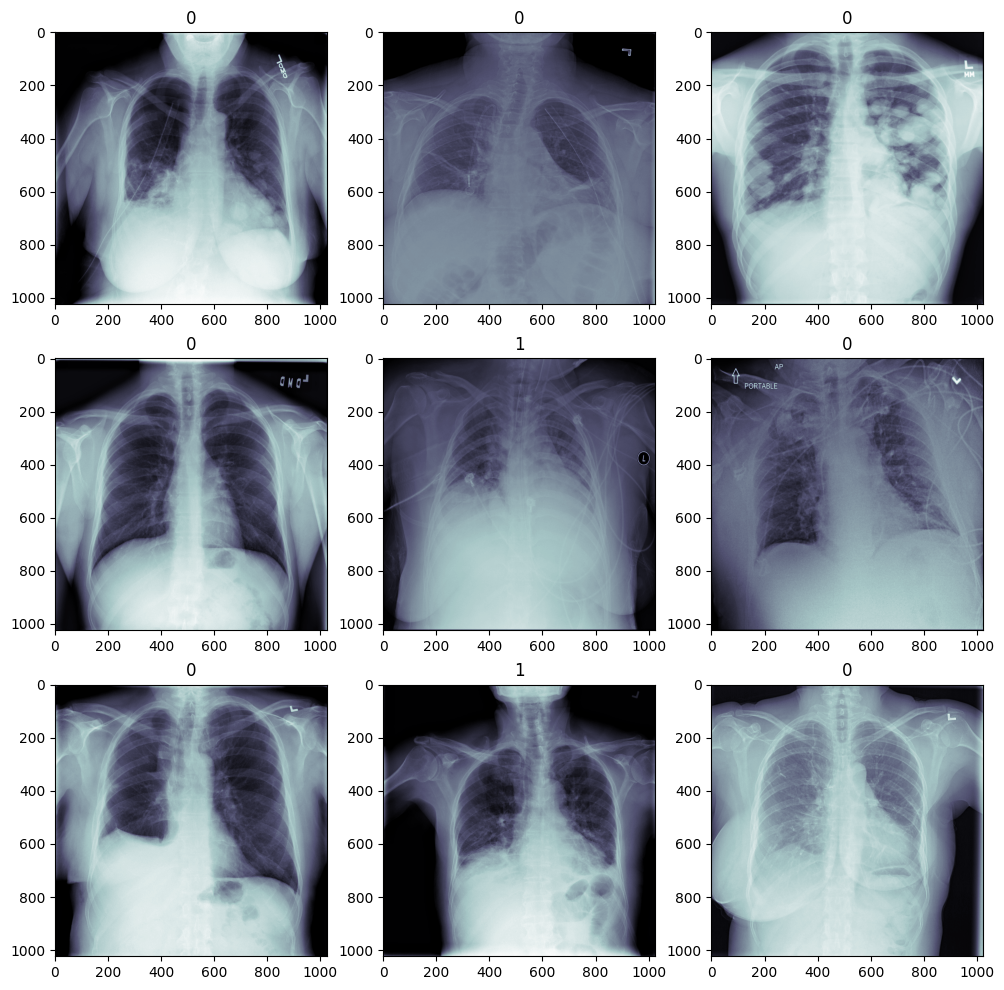

In [12]:
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = df.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm") # adding .dcm suffix
        dcm = pydicom.read_file(dcm_path).pixel_array # read the dicom file

        label = df["Target"].iloc[c]
        # print(dcm)

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

### creating data sample and prepare the dataset in the following structure:

Example of file structure

```
train <- training images
   └───have
   │   │   ---.jpeg
   │   │   ---.jpeg
   │   │   ...      
   └───have_not
       │   ---.jpeg
       │   ---.jpeg
       │   ...
```

In [13]:
train = os.listdir("/content/dataset/stage_2_train_images")
len(train)

26684

In [14]:
os.makedirs("./train", exist_ok=True)
os.makedirs("./train/have", exist_ok=True)
os.makedirs("./train/have_not", exist_ok=True)


for c,i in enumerate(tqdm(train)):
  ds = pydicom.dcmread(r"/content/dataset/stage_2_train_images/" + i)
  name = i.split(".")[0]
  img = Image.fromarray(ds.pixel_array)
  tar = df[df.patientId == name].values[0][5]

  if tar == 0:
    img.save("./train/have_not/" + name + ".jpeg")
  else:
    img.save("./train/have/" + name + ".jpeg")


  if c == 400:
    break

  0%|          | 0/26684 [00:00<?, ?it/s]

In [15]:
# Walk through train directory and list number of files
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'train'.
There are 0 directories and 298 images in 'train/have'.
There are 0 directories and 103 images in 'train/have_not'.


In [ ]:
# zip the train directory
!zip -r pneumonia.zip "./train"

In [17]:
# download the zip file to PC
from google.colab import files
files.download('pneumonia.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>